# Assortative Matching

A weakness of many models of infectious diseases is that they do not model well whom and how humans meet.

Our simulation based approach allows us to richly model human interactions through different contact models.
One important dimension of this is that we can distinguish recurrent and non-recurrent contacts:

1. Recurrent contacts are met repeatedly with certainty. Recurrent contacts allow us to model households, close friends, colleagues, class mates, etc..
2. Non-recurrent contacts are met infrequently or randomly. They include people like clients or customers at work, people visiting the same bar etc..

This notebook focuses on the second group of contacts and how they can be modeled using assortative matching. Though the contacts are non-recurrent, it does not mean that meeting one of two different people should be equally likely. Assortative matching means that individuals meet each other with differing probabilities based on their characteristics. For example, age is a strong assortative variable because people in the same age group are likely to share the same needs and interests and meet in the same places.

Assortative matching can be weaker or stronger and has been speculated to be [a reason why countries like Italy and Spain have been hit particularly badly by the pandemic](https://www.nytimes.com/2020/04/08/world/europe/adults-parents-home-coronavirus.html). Adults living with their parents or working in a grocery store are examples that lead to less assortativeness in matching. On the other hand, older people are more likely to attend classical concerts while rock concerts are more frequented by younger adults. Behaviors like these make it more likely for people to meet others of the same group.



What is the effect of assortative matching on the spread of an infectious disease? To study this question, we will employ a simple simulation exercise with the following key factors.

- We will simulate the spread of a disease in a sample of 100,000 people for one and a half years.
- The people are grouped into 5,000 groups which means there are 20 people in one group.
- We start with 10 initially infected people which are randomly drawn.
- People meet one person each period which is either from her own group or one of the others.
- The parameter to control the assortative matching is the probability that a person meets someone from her own group. The remaining probabability is distributed equally among the other groups. For example, if a person meets an individual from her own group with 50% chance, the probability for each other group is $\frac{1 - 0.5}{4999} \approx 0.00002$.
- We set the infection probability to 20%, i.e. if an infectious and a susceptible person meet, one in five times the susceptible person will catch the virus.

What are our intuitions?

Let us focus on the extreme scenarios:

- If all people meet only members of their own group (perfectly assortative matching), the disease will quickly die out. The disease will be completely contained in the groups where an initial infection exists. It is likely that all members of the group will get the disease.

- If there is no assortative matching at all, all contacts are equally likely and there is no containment effect. The disease will spread out and likely infect all people until the dynamics of herd immunity set in.
    
Thus, there are two forces playing against each other in moderate scenarios:

- Stronger assortative matching makes the disease spread more quickly in groups. But, at some turning point the probability of meeting someone in the same group which has not been infected yet becomes more and more unlikely. The disease will slowly spread to groups without initial infections.

- In the case of weak assortative matching, the disease will quickly spread over the whole population without affecting some subgroups harder than the rest.


Now, let us turn to the simulation which is only briefly commented. First, some import statements.

In [1]:
import io

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sid

plt.rc("axes.spines", top=False, right=False)

Next, we create the artificial data set with 100,000 individuals in 5,000 groups á 20 persons. The age group is arbitrarily chosen and only affects the course of the disease, but not the transmission process.

In [2]:
n_individuals = 100_000
n_groups = 5_000

initial_states = pd.DataFrame(
    {
        "id": np.arange(n_individuals),
        "group": np.repeat(np.arange(n_groups), n_individuals // n_groups),
        "age_group": "20 - 29",
    }
).astype({"group": "category", "age_group": "category"})

There are ten initially infected people randomly spread over the population.

In [3]:
n_initially_infected = 10

initial_infections = pd.Series(index=initial_states.index, data=False)
drawn_to_be_infected = np.random.choice(
    len(initial_infections), size=n_initially_infected
)
initial_infections.iloc[drawn_to_be_infected] = True

Here, we define the contact model. Each person meets one other person each period.

In [4]:
n_contacts_per_individual = 1


def meet_people(states, params):
    return pd.Series(index=states.index, data=n_contacts_per_individual)


contact_models = {
    "meet_people": {"model": meet_people, "assort_by": "group", "is_recurrent": False}
}

We take the default parameters and set the probability for the assortative matching to 10% and the infection probability to 20%. The latter will remain constant during the study.

In [5]:
index_columns = ["category", "subcategory", "name"]
params = pd.read_csv("../../../sid/params.csv", index_col=index_columns)

additional_params = """
category,subcategory,name,value
assortative_matching,meet_people,group,0.1
infection_prob,meet_people,meet_people,0.2
"""
additional_params = pd.read_csv(
    io.StringIO(additional_params), index_col=index_columns,
)

params = params.append(additional_params).sort_index()

additional_params

,,,value
category,subcategory,name,
assortative_matching,meet_people,group,0.1
infection_prob,meet_people,NaN,0.2


Here, we run the simulation and vary the parameter for the assortative matching from $0.1, 0.2, ..., 1$.

In [6]:
assortative_matching_params = np.round(np.linspace(0.1, 1, 10), 2)

data = {}
for value in assortative_matching_params:
    # Change assortative matching in params.
    params.loc[("assortative_matching", "meet_people", "group"), "value"] = value

    # Simulate the data.
    df = sid.simulate(
        params=params,
        initial_states=initial_states,
        initial_infections=initial_infections,
        contact_models=contact_models,
        duration={"start": "2020-01-01", "end": "2021-06-30"},
        seed=0,
    )

    # Save some data.
    infectious_last_seven_days = df.cd_infectious_false.between(-7, 0)
    r = (
        df.loc[infectious_last_seven_days]
        .compute()
        .resample("D", on="date")["n_has_infected"]
        .mean()
    )
    data_ = {
        "newly_infected": df.groupby(["date", "group"])["newly_infected"]
        .sum()
        .compute(),
        "infectious": df.groupby("date").infectious.mean().compute(),
        "ever_infected": df.groupby("date").ever_infected.mean().compute(),
        "dead": df.groupby("date").dead.sum().compute(),
        "r": r,
    }

    data[value] = data_

    # Remove reference to .parquet files on disk.
    del df

Now, let us visualize the spread of the disease. The following graph shows the number of newly infected people on a weekly-basis. Each curve represents a degree of assortative matching. For weaker assortative matching the curves peak rapidly between April and June.

In cases of stronger assortative matching, the curves flatten which has two implications. First, the current number of people needing care is lower, but, secondly, the duration of the pandemic is prolonged.

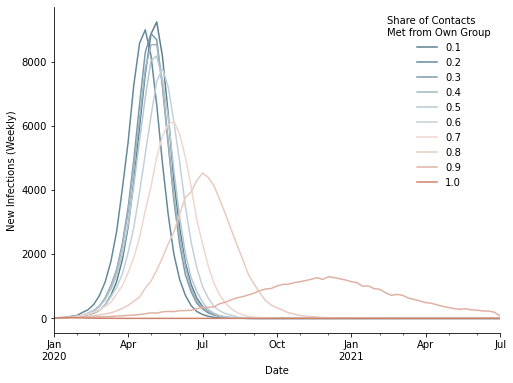

In [7]:
colors = [
    "#5c7f8e",
    "#63899a",
    "#7b9baa",
    "#9fb6c1",
    "#b6c8d0",
    "#c2d1d8",
    "#efd6cf",
    "#eacac0",
    "#e0b1a3",
    "#ce826c",
    "#c26246",
    "#b3563b",
]

fig, ax = plt.subplots(figsize=(8, 6))

for i, (value, data_) in enumerate(data.items()):
    data_["newly_infected"].reset_index(level="group").resample("W").sum()[
        "newly_infected"
    ].plot(ax=ax, label=str(value), color=colors[i])

plt.xlabel("Date")
plt.ylabel("New Infections (Weekly)")

plt.legend(title="Share of Contacts \nMet from Own Group", frameon=False)
plt.show()

What is impact of assortative matching on other statistics of the population? The following graphs show aggregated numbers on weekly basis.

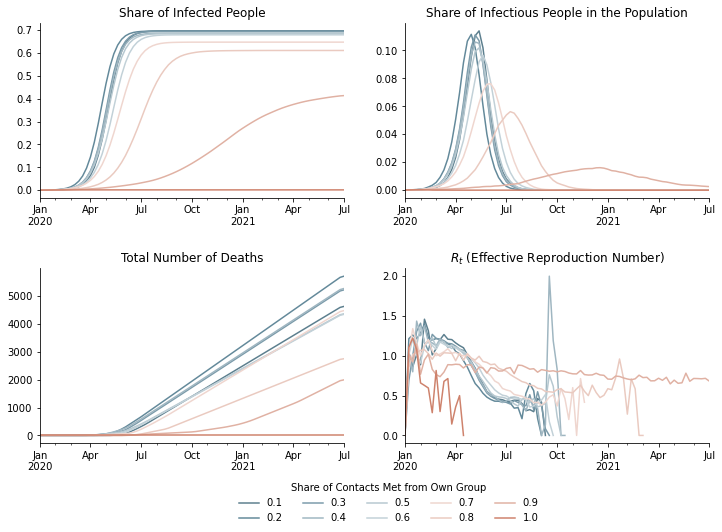

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.subplots_adjust(bottom=0.15, wspace=0.2, hspace=0.4)

axs = axs.flatten()

for i, (value, data_) in enumerate(data.items()):
    data_["ever_infected"].resample("W").mean().plot(
        ax=axs[0], label=str(value), color=colors[i]
    )
    data_["infectious"].resample("W").mean().plot(
        ax=axs[1], label=str(value), color=colors[i]
    )
    data_["dead"].resample("W").sum().cumsum().plot(
        ax=axs[2], label=str(value), color=colors[i]
    )
    data_["r"].resample("W").mean().plot(ax=axs[3], label=str(value), color=colors[i])

for ax in axs:
    ax.set_xlabel("")

axs[0].set_title("Share of Infected People")
axs[1].set_title("Share of Infectious People in the Population")
axs[2].set_title("Total Number of Deaths")
axs[3].set_title("$R_t$ (Effective Reproduction Number)")

handles, labels = axs[0].get_legend_handles_labels()
plt.figlegend(
    handles,
    labels,
    loc="lower center",
    bbox_to_anchor=(0.45, 0),
    ncol=5,
    frameon=False,
    title="Share of Contacts Met from Own Group",
)

plt.show()

The graph in the upper left corner shows the share of people who were infected at some point during the pandemic and are assumed to be immune. Each curve converges to a share of people at which point new infections stop and herd immunity sets in. Herd immunity means that an infectious person is unlikely to meet a susceptible person and, thus, the disease stops spreading.

The curves have different upper bounds which means that the share of the population necessary to achieve herd immunity is not some fixed, magic number. Instead, it is dependent on the disease itself and on individual behavior. Lower degrees of assortative matching ranging from 0.1 to 0.6 lead to herd immunity if roughly 70% of the population are immune. For higher degrees of assortative matching like 0.9, herd immunity is already achieved when roughly 40% of the population are immune.

The figure in the upper right corner shows the current share of infectious people in the whole population. The shapes of the curves are very similar to the ones in graph on new infections.

The total number of deaths are shown in the lower left corner. You can see how the trends are delayed in comparison the numbers on infections.

The last graph shows the effective reproduction rate $R_t$ which is the average number of infections caused by an infectious individual at any point in time. The differences in $R_t$ between the scenarios seem small in the time period from January to April where values lie between 1.0 and 1.5. But, the results can be vastly different when the effective reproduction rate is constant despite exponential growth in the number of immune (because already infected) people.